# Music machine learning - Advanced neural networks

### Author: Philippe Esling (esling@ircam.fr)

In this course we will cover
1. An introduction to [convolutions](#convolution) and how they can be used
2. Defining a [Convolutional Neural Network](#cnn) in Pytorch for image classification 
3. Coding our own [convolutional layer](#layer)
4. An explanation on [recurrent networks](#rnn) in practice

<a id="convolution"></a>
## Convolutions

In purely mathematical terms, convolution is a function derived from two given functions by integration which expresses how the shape of one is modified by the other. In simpler (discrete) terms, the convolution product of a matrix by a smaller one can be seen as _filtering_ the large matrix. Hence we slide the small matrix over the large one and compute local products at each position. Therefore the convolution operator $\star$ computes at each position $n$

$$
(f \star g)[n]=\sum _{m=-M}^{M}f[n-m]g[m].
$$

An example of this operation is shown here

<img src="images/02_convolution.png" align="center"/>

This operation can be used to _filter_ the image (as in the _gaussian blur_ operator), or _detect_ features (such as edges). 

Given an 32x32 image with RGB channels, we can represent it as a tensor of shape `(32, 32, 3)` which is (height, width, channels). When we perform convolution, we need a filter that has the same channel depth as the image. For example, we can use a 5x5 filter which is of shape `(5, 5, 3)` and slide it across the image left to right, top to bottom with a stride of 1 to perform convolution. We are going to perform this in numpy, depending on a certain amount of parameters, which define the behavior of our convolution

* `height` and `width`: spatial extend of the filters
* `S`: stride size (number of steps to jump to the next position)
* `P`: amount of padding (adding zeros in the original matrix)

In [2]:
import numpy as np
# Padding
pad = 2
stride = 1
height, width = 5, 5
# A random fake image
x = np.random.randn(3, 32, 32)
x_h, x_w = x.shape[1:]
# Our convolution kernel
weight = np.random.randn(3, 5, 5)
# Padding the original image
x_pad = np.pad(x, pad_width=((0, 0,), (pad, pad), (pad, pad)), mode='constant', constant_values=0)
# We can expect the output size to be
h_out = int(1 + (x_h + 2 * pad - height) / stride)
w_out = int(1 + (x_w + 2 * pad - width) / stride)
# So we will store our result in
y = np.zeros((1, h_out, w_out))

Computing the convolution itself can be performed by using the following loop (which amounts to _slide_ our kernel across the large matrix)

In [3]:
# Sliding the kernel across the matrix
for h in range(h_out):
    for w in range(w_out):
        i, j = h * stride, w * stride
        conv_sum = np.sum(x_pad[:, i:i+height, j:j+width] * weight)
        y[0, h, w] = conv_sum

We can witness the effect of this operation with the following plot

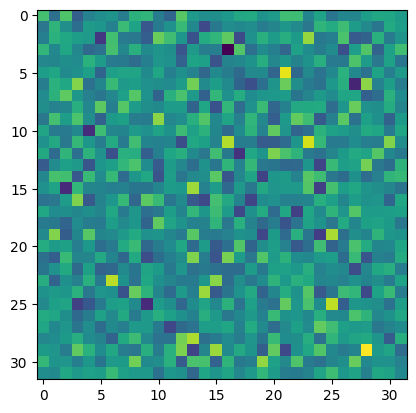

In [4]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(y[0])
plt.show()

## Convolutional Neural Networks (CNN)

Convolutional NNs (CNNs) rely on convolution in place of general matrix multiplication. They are specialized for processing data with a known grid-like topology and are among the best performing systems in classification/recognition tasks. Each layer in a CNN consists in a set of $N$ _filters_ called _kernels_, that are convolved across the input. If we denote as $\{k^l_n\}_{n\in[1;N]}$ the set of kernels for layer $l$, these all share a unique _kernel size_. By convolving each one of its $N$ kernels across a d-dimensional input $x$, a convolutional layer produces $N$ d-dimensional outputs called _feature maps_, denoted as $\{a^l_n\}_{n\in[1;N]}$. Hence, the computation of the $n$-th activation map in layer $l$ for input $x$ is defined as:

$$
\begin{equation}
a^l_n = \sum_{m=1}^{M} k^l_n \star x_m + b^l_n
\end{equation}
$$

Thus, as depicted in the following Figure, the feature map corresponding to kernel $n$ consists in the sum of the d-dimensional discrete convolutions (denoted by the $\star$ operator) between the kernel $n$ and each one of the d-dimensional data $\{x_m\}_{m\in[1;M]}$, plus a bias $b$. A convolutional layer is thus a 3-dimensional tensor $h \in \mathcal{T}_{N,I,J}(\mathbb{R})$ where $N$ is the number of features maps while $I$ and $J$ are respectively the _width_ and _height_ of the maps. 

<img src="images/02_cnns.png" align="center"/>

This can be seen as replacing our _neurons_ by _feature detectors_ (the convolutional kernels), which will increasingly process the image. In the following, we will first use the high-level interface of `Pytorch` to define a CNN

<a id="cnn"></a>
## Defining a CNN in Pytorch

Defining a convolutional network in Pytorch is quite easy, as we can rely on the `nn` module, which contains all the required layers

In [8]:
import torch
import torch.nn as nn

In the previous course, we have seen that we could define our network in a very simple way, by using the `Sequential` model definition. Here we define a CNN followed by a MLP, as seen in the previous course

In [9]:
# Define the input dimensions
in_size = 1000
# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Conv2d(3, 6, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, 5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120),
    nn.ReLU(),
    nn.Linear(120, 84),
    nn.ReLU(),
    nn.Linear(84, 10),
    nn.Softmax(dim=1)
)

Another way to implement the networks in Pytorch is to use the `functional` approach. In this version, each layer is seen as a function, that we apply on sucessive inputs. For instance, we can define one layer of fully-connected units and apply it to some inputs as follows.


In [10]:
import torch.nn.functional as F
# Define one layer
layer = nn.Linear(100, 10)
# Define the non-linearity
activation = nn.ReLU()
# Create some random input
inputs = torch.rand(32, 100)
# Apply our layers
outputs = activation(layer(inputs))
# Equivalently, as ReLU is parameter-free
outputs = F.relu(layer(inputs))

Now to make this even cleaner, we can define our own `nn.Module`, which is a `Pytorch` class representing models. To do so, we can define a sub-class, and implement the functions `__init__` (defining our layers) and `forward` (explaining how our forward pass will behave)

***

**Exercise**
1. Implement a CNN in Pytorch using the `functional` library

***

<!--
<div class="alert alert-info" markdown=1><h4>Exercise</h4>
1. Implement a CNN in Pytorch using the `functional` library
</div>
-->


In [19]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.pool2 = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(16 * 5 * 5,120)
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,10)


    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch?
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x



model = CNN()

### Training the network

In order to test our CNN, we are going to try to perform image classification. To do so, we can use the simplifications for data loading contained in `torchvision`

In [13]:
import torchvision
import torchvision.transforms as transforms

The `torchvision` package provides pre-coded simplification to download and use the major image datasets, notably `MNIST` and `CIFAR`, which are the baseline datasets for testing image ML models. The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In the following code, we are going to load the `CIFAR10` _train_ and _test_ sets. **Note that this code will automatically download the dataset if you did not have it before, and place it in the `data` folder, so this might take a bit of time**

In [15]:
# Transforms to apply to the images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Import the train dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)  
# Import the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)
# Classes in the CIFAR dataset
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Using your knowledge from the previous course, you can now define an optimization problem, and implement the training loop for your model

***

**Exercise**
1. Define a `criterion` and `optimizer`
2. Fill in the training loop to train your model

***

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.001,momentum= 0.9) #ou ADAM à la place de SGD


In [20]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.303
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.304
[1, 10000] loss: 2.304
[1, 12000] loss: 2.305
[2,  2000] loss: 2.304
[2,  4000] loss: 2.305
[2,  6000] loss: 2.304
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
[2, 12000] loss: 2.304
Finished Training


In [23]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
#plt.figure()
#plt.imshow(torchvision.utils.make_grid(images))
#plt.show()
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

GroundTruth:  cat   ship  ship  plane


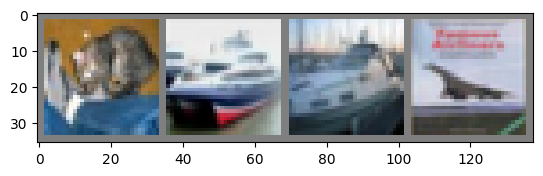

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))


on retrouve bien un chat, un bateau, un bateau et un avion.

Now that your model is trained, you can test it by feeding some new (unseen) images and see if it is able to classify them correctly

<a id="layer"></a>
## Coding our own convolutional layer

Although `Pytorch` comes packed with pre-implemented layers, we can also very easily define our own layers. This will be useful when you start doing research and propose your own way of processing the information. A large advantage of `Pytorch` is that it performs _automatic gradient differentiation_, this means that we simply have to define how the `forward` pass will work, and `Pytorch` will automatically infer the backpropagation equations, without us having to go through any complicated differentiation

In the following, we are going to redefine the `Conv2d` layer, by computing the operation ourselves.

***

**Exercise**
1. Complete the `forward` function to compute a convolution

***

In [ ]:
class MyConv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, dilation=1, padding=0, stride=1):
        super(MyConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size)
        self.kernal_size_number = kernel_size * kernel_size
        self.out_channels = out_channels
        self.dilation = (dilation, dilation)
        self.padding = (padding, padding)
        self.stride = (stride, stride)
        self.n_channels = n_channels
        self.weights = nn.Parameter(torch.Tensor(self.out_channels, self.n_channels, self.kernal_size_number))

    def forward(self, x):
        width = self.calculateNewWidth(x)
        height = self.calculateNewHeight(x)
        windows = self.calculateWindows(x)
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        return result  

    def calculateWindows(self, x):
        windows = F.unfold(x, kernel_size=self.kernel_size, padding=self.padding, dilation=self.dilation, stride=self.stride)
        windows = windows.transpose(1, 2).contiguous().view(-1, x.shape[1], self.kernal_size_number)
        windows = windows.transpose(0, 1)
        return windows

    def calculateNewWidth(self, x):
        return ((x.shape[2] + 2 * self.padding[0] - self.dilation[0] * (self.kernel_size[0] - 1) - 1) // self.stride[0]) + 1

    def calculateNewHeight(self, x):
        return ((x.shape[3] + 2 * self.padding[1] - self.dilation[1] * (self.kernel_size[1] - 1) - 1)// self.stride[1]) + 1

# Testing the code directly
conv = MyConv2d(3, 1, 3)
x = torch.randn(1, 3, 24, 24)
out = conv(x)
out.mean().backward()
# Check that we do have gradients
print(conv.weights.grad)

Now you can use your own `MyConv2d` layer, and use it in real-life scenarios, by trying to change your previous model to use your own layer instead.

## Recurrent Neural Networks (RNN)

Recurrent neural networks (RNNs) are a family of models designed to process time series and sequential data, which perform remarkably in applications such as speech recognition or machine translation. The ability of RNNs to model correlations between successive computations through recurrent connection make them efficient for temporal problem as they provide a form of _memory_. 

To model structured sequential data, NNs can be augmented with recurrent loops, which allow to retain information across time steps. Considering a sequence $\mathbf{X}=\{\mathbf{x}_t\}$, dependencies between elements are managed by having a recurrent hidden state $\mathbf{h}_t$ at time $t$ in the network. The value of $\mathbf{h}_t$ at each time depends of the previous time and the input, as depicted in the following figure. 

<img src="images/02_rnn.png" align="center"/>

Formally, each hidden state is updated as

$$
\begin{equation}
\mathbf{h}_t = 
\begin{cases} 
\phi_{\mathbf{\mathbf{\theta}}}(\mathbf{x}_0) & \mbox{if } t=0 \\ 
\phi_{\mathbf{\mathbf{\theta}}}(\mathbf{h}_{t-1},\mathbf{x}_t), & \mbox{otherwise} 
\end{cases}
\label{eq:RNNhiddenupdate}
\end{equation}
$$ 

### Implementing a simple rnn

Here's a simple one-to-many vanilla recurrent neural network example in functional form. If we were to produce `h[t]`, we need some weight matrices, `h[t-1]`, `x[t]` and a non-linearity `tanh`.

$$
h_{t} = tanh(W_{hh}h_{t-1} + W_{xh}x_{t} + B_{h})
$$

Since this is a **one-to-many** network, we'd want to produce an output `y[t]` at every timestep, thus, we need another weight matrix that accepts a hidden state and project it to an output.

$$
y_{t} = W_{hy}h_{t} + B_{y}
$$

Now that we know how to use the `Functional` library of `Pytorch`, we are going to implement our own simple RNN layer as previously. This time, we do not provide the content of the `__init__` function, so think carefully of what parameters you will need and how you need to define them.

***

**Exercise**
1. Complete the `__init__` function to instantiate all required parameters
1. Complete the `forward` function to compute the forward pass

***

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RecurrentNetwork(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        """ Defines the required variables """
        super(RecurrentNetwork, self).__init__()
        
        ######################
        # YOUR CODE GOES HERE
        ######################

    
    def forward(self, x):
        """ Computes the forward pass """
        
        ######################
        # YOUR CODE GOES HERE
        ######################
        
        return output

We can then forward propagate our information inside our network

In [ ]:
in_size = 4
input_vector = torch.ones(16, in_size)
simple_network = RecurrentNetwork(in_size, 10, 5)
# Notice that same input, but leads to different ouptut at every single time step.
print(simple_network(input_vector))
print(simple_network(input_vector))
print(simple_network(input_vector))

As usual, `Pytorch` also comes packed with some pre-coded recurrent layers. You can go check the documentation to find how to use these.